### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

# Remaining Useful Life (RUL) Prediction with MLP

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) for remaining useful life prediction using the NASA Turbofan Engine dataset and the helper functions from `modelling_helper.py`.

## Introduction

Remaining Useful Life (RUL) prediction is a key technology for predictive maintenance systems across industrial sectors. In automotive applications, accurate RUL estimation provides:

- **Proactive maintenance scheduling** - Reducing unplanned downtime through failure prediction
- **Cost optimization** - Extending component operational life while avoiding premature replacement
- **Safety improvement** - Early identification of potential component failures
- **Fleet optimization** - Data-driven maintenance scheduling across vehicle fleets
- **Warranty analysis** - Understanding component degradation patterns for design optimization

### Notebook Structure

1. **Import Libraries and Helper Functions**
2. **Load and Explore the NASA Turbofan Engine Dataset**
3. **Data Visualization**
4. **Data Preprocessing for MLP**
5. **Create and Build MLP Model**
6. **Train the Model**
7. **Model Export and Conversion**
8. **Model Evaluation**
9. **Compiling the Model for AURIX&trade;**
10. **Evaluate Execution Timing**

## Import Libraries and Helper Functions

In [1]:
import sys
import os

# Add the parent directory to the Python path so we can import from central_scripts
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from modelling_helper import *

origin = "torch"

train_data_path = "data/train_FD001.txt"
test_data_path = "data/test_FD001.txt"
test_RUL_path = "data/RUL_FD001.txt"

## Load and Investigate the NASA Turbofan Engine Dataset

This project uses the **NASA Turbofan Engine Degradation Simulation Dataset** (also known as the NASA C-MAPSS dataset). The dataset contains:

- **Training data**: Run-to-failure time series data from multiple aircraft engines
- **Test data**: Partial time series data for engines with unknown remaining useful life
- **Ground truth**: Actual RUL values for the test engines

The data loading process includes:
- **Automatic download**: If data files are not found locally, they are automatically downloaded from the official NASA repository
- **Data normalization**: For better model training the train data is normalized
- **Feature filtering**: Remove features that do not carry meaningful information by checking the standard deviation of the data. Features with a standard deviation lower than 0.02 are excluded

**Data Source**: The dataset is automatically downloaded from the [NASA Prognostics Data Repository](https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository) when needed.

 A. Saxena and K. Goebel (2008). “Turbofan Engine Degradation Simulation Data Set”, NASA Prognostics Data Repository, NASA Ames Research Center, Moffett Field, CA

In [2]:
train_data = load_dataframe(train_data_path)
train_data, scaler = normalize_data(train_data)

removed_cols = clean_data(train_data)
train_data.drop(removed_cols, axis=1, inplace=True)
train_data = add_rul(train_data)

print(f"Training data shape: {train_data.shape}")
print(f"Removed columns: {removed_cols}")
train_data

Loading data from local file: data/train_FD001.txt
Removing completely empty columns: ['sensor_22', 'sensor_23']
Removed columns: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Training data shape: (20631, 20)
Removed columns: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


,unit_number,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,191
1,1,2,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,190
2,1,3,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,189
3,1,4,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,188
4,1,5,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.178822,-1.031720,1.618000,1.216258,2.188375,0.141683,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113,4
20627,100,197,-0.727453,-1.714186,1.717992,2.279706,2.738351,0.141683,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764,3
20628,100,198,0.186933,-0.008022,1.478011,1.946971,2.138377,0.141683,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481,2
20629,100,199,-0.498857,1.015677,1.098043,2.403666,1.955051,0.141683,-3.036719,2.160330,0.383884,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072,1


## Data Visualization

- Time series patterns
- RUL distribution
- Sensor correlation analysis

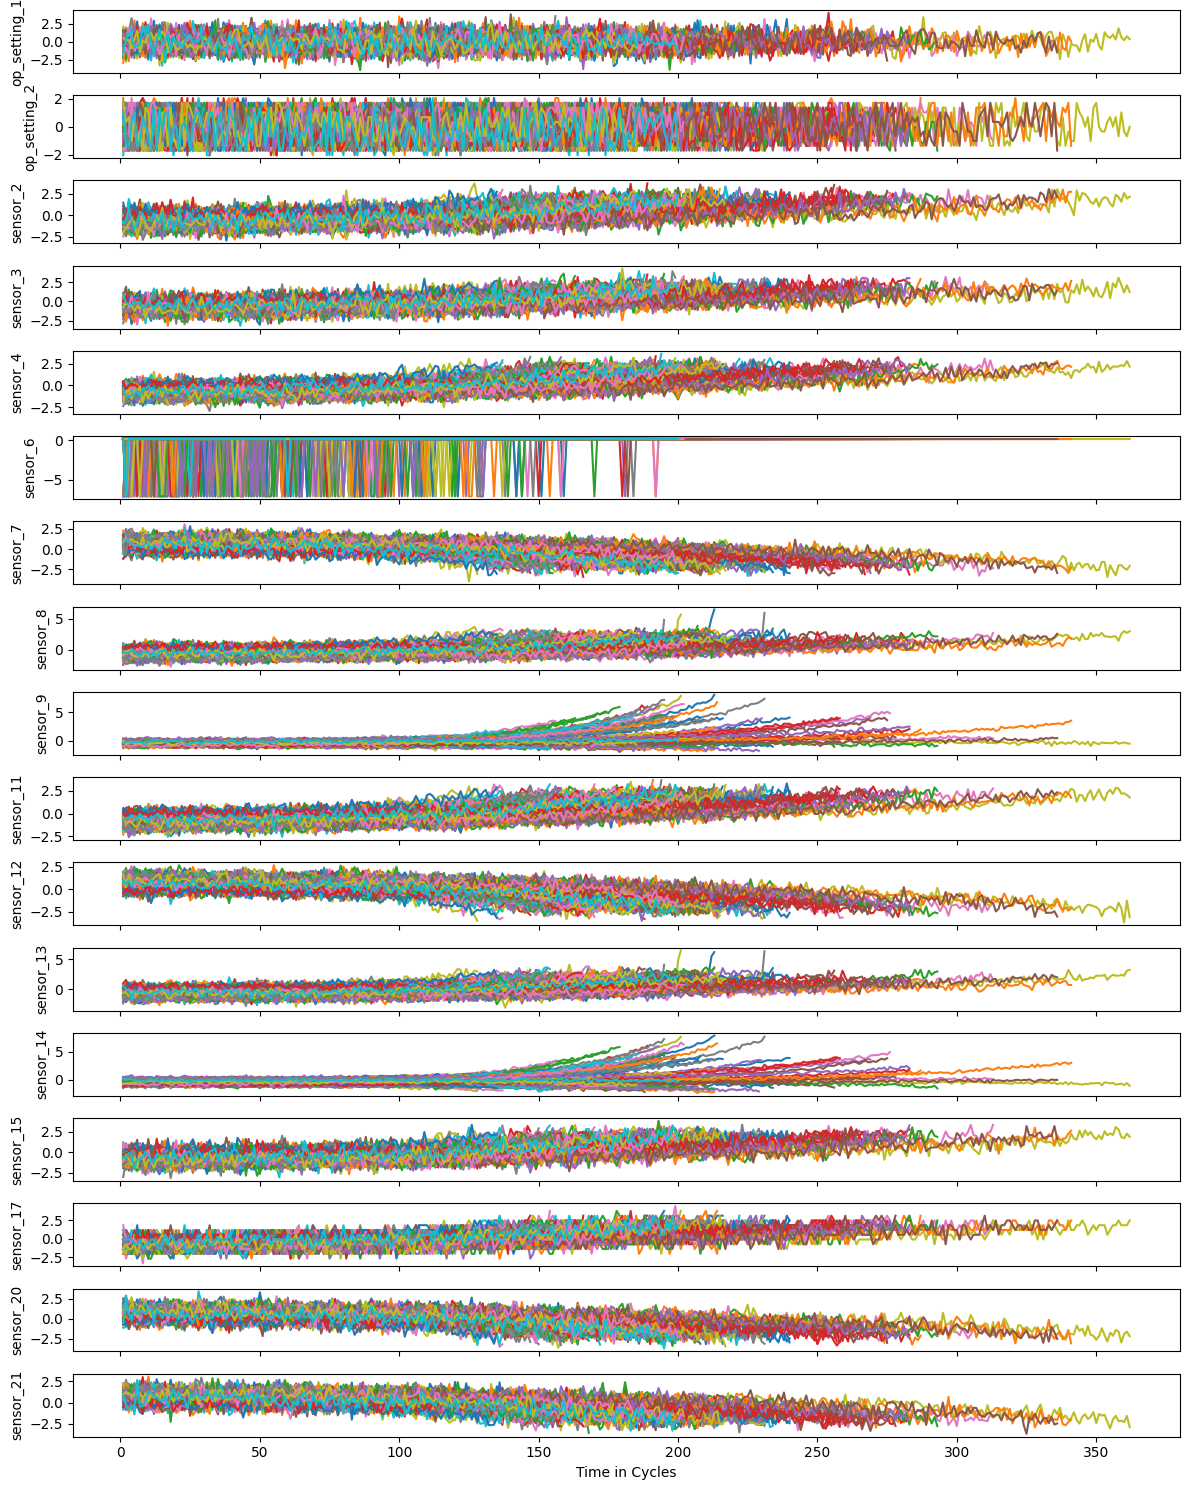

In [3]:
sensor_cols = [
    col for col in train_data.columns if "sensor" in col or "op_setting" in col
]

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(12, 15), sharex=True)

for i, sensor in enumerate(sensor_cols):
    for unit in train_data["unit_number"].unique():
        unit_data = train_data[train_data["unit_number"] == unit]
        axes[i].plot(unit_data["time_in_cycles"], unit_data[sensor])
    axes[i].set_ylabel(sensor)

axes[-1].set_xlabel("Time in Cycles")
plt.tight_layout()
plt.show()

## Data Preprocessing for MLP

- Turn into sequences of a defined length. The training data will have the shape `n_samples * sequence_length * n_features`
- Split into training and validation data
- For MLP, sequences will be flattened into feature vectors

In [4]:
from sklearn.model_selection import train_test_split

sequence_length = 50
# Prepare sequences
X, y = prepare_train_sequences(train_data, sequence_length)

# Split the data into 90% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Number of features per sequence: {X_train.shape[1] * X_train.shape[2]}")

X_train shape: (14067, 50, 17)
X_val shape: (1564, 50, 17)
Number of features per sequence: 850


## Create and Build MLP Model

- Tweak the `layer_units` list to test the effect of the model architecture on predictions

In [5]:
from torchinfo import summary

# MLP architecture parameters
layer_units = [128, 64, 32]  # Hidden layer units
input_size = X_train.shape[1] * X_train.shape[2]  # Flattened sequence
output_size = 1  # Single RUL value
dropout_rate = 0.05

model = MLPmodel(
    layer_units=layer_units,
    input_size=input_size,
    output_size=output_size,
    dropout_rate=dropout_rate,
)

# Print model summary
print(f"Model type: {model.model_type}")
print(f"Input size: {input_size}")
print(f"Layer units: {layer_units}")
summary(model)

Model type: MLP
Input size: 850
Layer units: [128, 64, 32]


Layer (type:depth-idx)                   Param #
MLPmodel                                 --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       108,928
│    └─Linear: 2-2                       8,256
│    └─Linear: 2-3                       2,080
│    └─Linear: 2-4                       33
├─ModuleList: 1-2                        --
│    └─Dropout: 2-5                      --
│    └─Dropout: 2-6                      --
│    └─Dropout: 2-7                      --
Total params: 119,297
Trainable params: 119,297
Non-trainable params: 0

## Train the Model

- Flatten the input data for MLP processing
- The training process uses early stopping to avoid overfitting.
- To ensure proper convergence learning rate reduction is used when training stalls.

Flattened input for MLP:
X_train_final shape: (14067, 850)
X_val_final shape: (1564, 850)
Epoch [1/10], Train Loss: 1987.5296, Val Loss: 1133.1146, LR: 0.010000
Epoch [2/10], Train Loss: 1138.0509, Val Loss: 1127.4531, LR: 0.010000
Epoch [3/10], Train Loss: 947.7216, Val Loss: 847.8699, LR: 0.010000
Epoch [4/10], Train Loss: 774.3787, Val Loss: 765.0297, LR: 0.010000
Epoch [5/10], Train Loss: 625.8170, Val Loss: 702.7409, LR: 0.010000
Epoch [6/10], Train Loss: 552.0896, Val Loss: 891.4181, LR: 0.010000
Epoch [7/10], Train Loss: 453.1760, Val Loss: 711.9613, LR: 0.010000
Epoch [8/10], Train Loss: 411.4439, Val Loss: 749.7298, LR: 0.010000
Epoch [9/10], Train Loss: 354.3164, Val Loss: 689.1973, LR: 0.010000
Epoch [10/10], Train Loss: 340.1354, Val Loss: 997.4143, LR: 0.010000


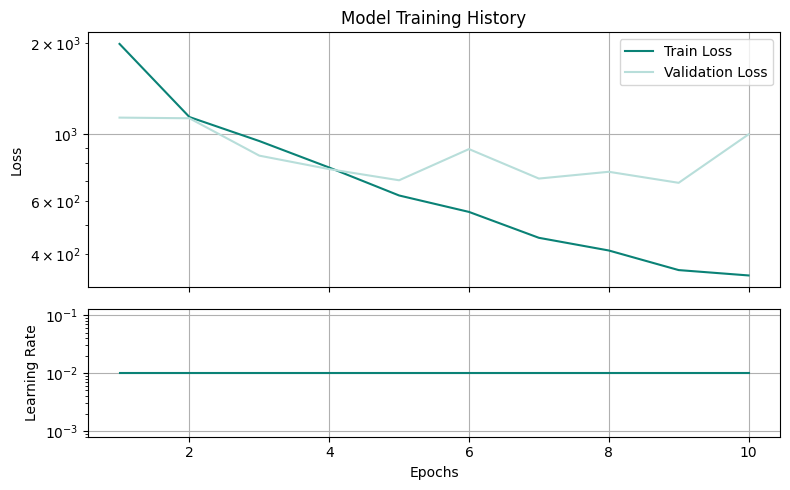

Best model loaded.


In [6]:
# Flatten input data for MLP
X_train_final = X_train.reshape(X_train.shape[0], -1)  # Flatten for MLP
X_val_final = X_val.reshape(X_val.shape[0], -1)  # Flatten for MLP

print("Flattened input for MLP:")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")

train_loss, val_loss, lr = train_model(
    model=model,
    X_train=X_train_final,
    y_train=y_train,
    X_val=X_val_final,
    y_val=y_val,
    initial_lr=0.01,
    num_epochs=10,  # Reduced for faster training in demo
)

plot_training_progress(train_loss, val_loss, lr)

# Load the best model - check if file exists first
checkpoint_path = "model_checkpoints/best_model.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Best model loaded.")
else:
    print("No checkpoint found. Using current model state.")

# Export Model to ONNX

- Generate a model name based on its architecture and loss
- Save the model together with a test in- & output

In [7]:
# Generate model name
model_name = f"{model.model_type}_layers-{len(layer_units)}_loss-{min(val_loss):.1f}"
model_name = model_name.replace(".", "-")

# Prepare input and output for model export
input_target = X_train[0].astype(np.float32)  # Single sequence
input_target = input_target.flatten()  # Flatten the input for MLP
output_target = get_predictions(origin, model, input_target)

save_all(model_name, input_target, output_target, model, origin)

print(f"Model saved as: {model_name}")
print(f"Input shape for export: {input_target.shape}")
print(f"Output shape: {output_target.shape}")

Directory created: out/MLP_layers-3_loss-689-2/test_MLP_layers-3_loss-689-2
Model loaded from out/MLP_layers-3_loss-689-2/test_MLP_layers-3_loss-689-2/model.onnx
Model saved as: MLP_layers-3_loss-689-2
Input shape for export: (850,)
Output shape: (1, 1)


## Model Evaluation

### Load Test Data

Data that was not used during model training.

In [8]:
test_data = load_dataframe(test_data_path)
test_RUL = pd.read_csv(test_RUL_path, names=["RUL"], header=None)
test_data, scaler = normalize_data(test_data, scaler)

test_data.drop(removed_cols, axis=1, inplace=True)

X_test, y_test = prepare_test_sequences(test_data, test_RUL, sequence_length)

print(f"Test data shape: {test_data.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

test_data.head()

Loading data from local file: data/test_FD001.txt


Removing completely empty columns: ['sensor_22', 'sensor_23']
Test data shape: (13096, 19)
X_test shape: (92, 50, 17)
y_test shape: (92,)


,unit_number,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,1.055599,1.015677,0.678077,-0.853550,-1.191480,0.141683,0.601408,-0.798093,-0.682579,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-0.781710,0.241943,0.774097
1,1,2,-1.230366,-1.031720,-1.941707,-0.338137,-1.501467,0.141683,1.674769,-1.220725,-0.490117,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-0.136018,1.127183,0.941305
2,1,3,0.141213,0.333211,-0.441831,-0.584426,-0.843717,0.141683,0.838677,-0.657216,-0.375093,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-0.136018,1.459148,1.172256
3,1,4,1.924266,-0.008022,-0.481827,-1.044384,-0.279297,0.141683,0.793483,-0.938970,-0.903570,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.427402,1.016528,0.775945
4,1,5,0.644125,-0.008022,-0.341839,-0.543650,-0.779276,0.141683,0.895170,-1.220725,-0.937081,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-2.073094,0.961200,1.138999


### Make Model Predictions

- Fix the model batch size to 1
- Simplify the model
- Make predictions with the original and simplified models
- Compare the predictions and check if they are identical

In [9]:
model_folder, onnx_model_file = get_output_paths(model_name)
y_pred_test = pd.DataFrame(
    {
        "y_pred": predict_with_onnx(
            onnx_model_file, X_test.reshape(X_test.shape[0], -1)
        ).reshape(
            -1,
        ),
        "y": y_test,
        "Train_test": "Test",
    }
)

y_pred_train = pd.DataFrame(
    {
        "y_pred": predict_with_onnx(
            onnx_model_file, X_train.reshape(X_train.shape[0], -1)
        ).reshape(
            -1,
        ),
        "y": y_train,
        "Train_test": "Train",
    }
)

y_pred = pd.concat([y_pred_train, y_pred_test])

### Performance Analysis

- Mean squared error (MSE) as loss
- R2 as statistical metric for the predictive quality of the model, R2 = 1 indicating a perfect model
- Compare the performance on train and test data

In [10]:
kpi_df = calculate_kpis(y_pred)
print("Model Performance Metrics:")
print(kpi_df)

Model Performance Metrics:
          Train        Test
MSE  201.051651  444.975922
R2     0.938746    0.736568


### Plot true vs. predicted RUL

- Assess model performance by directly comparing true and predicted values
- Better correlation indicates a better model

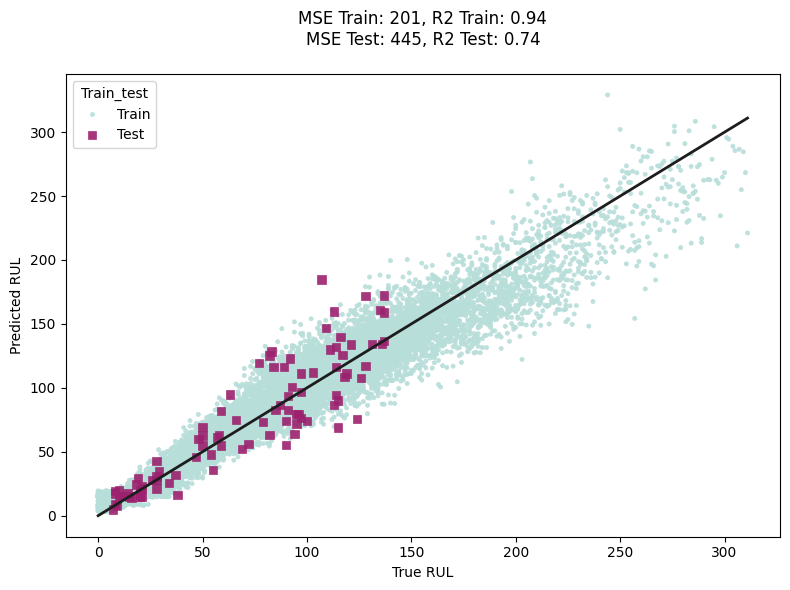

In [11]:
plot_true_vs_predicted(y_pred, kpi_df)

## Compiling the Model for AURIX&trade;

We now generate a C file from the ONNX and convert this into an elf file next. The elf file can be deployed on the CPUs of an AURIX&trade; TC3.

- Specify the `model_folder` and the `target` hardware

In [12]:
ensure_docker_container()

Docker container '' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


In [13]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


## Evaluate Execution Timing

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


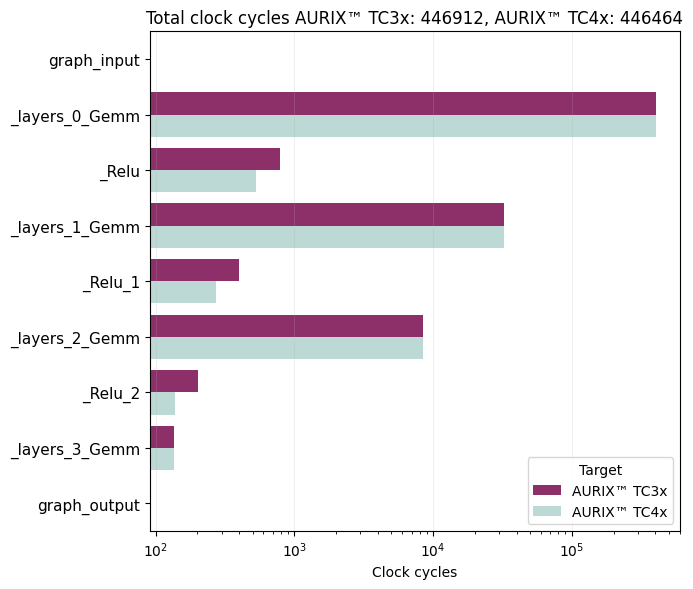

In [14]:
plot_execution_timing(model_name)